In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import skimage.transform
from tqdm import tqdm, tqdm_notebook
import skimage
from skimage import io
from skimage.color import rgb2gray
from skimage import feature as ft
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, array_to_img

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
imageSize=224

train_dir = 'data/train/'
validation_dir = 'data/validation/'
test_dir = 'data/test/'

In [4]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['benign']:
                label = 0
            elif folderName in ['malignant']:
                label = 1
#             else:
#                 label = 4
            for image_filename in tqdm_notebook(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_gray = rgb2gray(img_file)
                    img_lbp = ft.local_binary_pattern(img_gray, 8 * 8, 8)
                    img_file = skimage.transform.resize(img_lbp, (imageSize, imageSize, 3), mode='constant')
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [5]:
X_train, y_train = get_data(train_dir)

In [6]:
X_validation, y_validation= get_data(validation_dir)

In [7]:
X_test, y_test= get_data(test_dir)

In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (320, 224, 224, 3)
y_train shape: (320,)
X_validation shape: (67, 224, 224, 3)
y_validation shape: (67,)
X_test shape: (39, 224, 224, 3)
y_test shape: (39,)


In [9]:
y_trainHot = to_categorical(y_train, num_classes = 2)
y_valHot = to_categorical(y_validation, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_trainHot.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_valHot.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_testHot.shape)

X_train shape: (320, 224, 224, 3)
y_train shape: (320, 2)
X_validation shape: (67, 224, 224, 3)
y_validation shape: (67, 2)
X_test shape: (39, 224, 224, 3)
y_test shape: (39, 2)


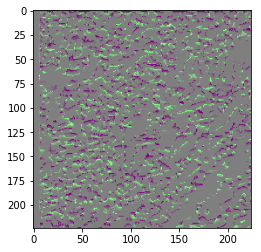

In [11]:
plt.imshow(array_to_img(X_test[0]), cmap= "gray")

In [12]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
y_testHot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [14]:
input_shape = (imageSize, imageSize, 3)
output_classes = 2

from keras.applications import ResNet50
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model_dense_conv = ResNet50(weights='imagenet', include_top=False)  
    #Create your own input format
keras_input = Input(shape= input_shape, name = 'image_input')
    
    #Use the generated model 
output_dense_conv = model_dense_conv(keras_input)
    
    #Add the fully-connected layers 
x = Flatten(name='flatten')(output_dense_conv)
x = Dense(1024, activation= 'relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='fc1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation= 'relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='fc2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(output_classes, activation='softmax', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='predictions')(x)
    
    #Create your own model 
model = Model(inputs=keras_input, outputs=x)

In [15]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
# sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
# rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

model.compile(optimizer = adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(
  X_train, y_trainHot,
  batch_size = 8,
  epochs = 20,
  verbose=2,
  validation_data = (X_validation, y_valHot))

Train on 320 samples, validate on 67 samples
Epoch 1/20
 - 20s - loss: 1.6629 - acc: 0.4906 - val_loss: 1.7359 - val_acc: 0.3433
Epoch 2/20
 - 5s - loss: 1.4979 - acc: 0.4812 - val_loss: 1.6077 - val_acc: 0.2985
Epoch 3/20
 - 5s - loss: 1.5219 - acc: 0.4875 - val_loss: 1.6131 - val_acc: 0.3433
Epoch 4/20
 - 5s - loss: 1.3219 - acc: 0.5969 - val_loss: 1.8047 - val_acc: 0.3433
Epoch 5/20
 - 5s - loss: 1.2969 - acc: 0.5781 - val_loss: 1.7923 - val_acc: 0.3433
Epoch 6/20
 - 5s - loss: 1.1485 - acc: 0.6031 - val_loss: 1.6039 - val_acc: 0.3731
Epoch 7/20
 - 5s - loss: 1.0924 - acc: 0.6438 - val_loss: 1.8762 - val_acc: 0.3582
Epoch 8/20
 - 5s - loss: 1.0797 - acc: 0.6375 - val_loss: 1.7167 - val_acc: 0.4179
Epoch 9/20
 - 5s - loss: 1.1545 - acc: 0.6187 - val_loss: 1.6100 - val_acc: 0.3731
Epoch 10/20
 - 5s - loss: 1.1378 - acc: 0.6219 - val_loss: 1.6806 - val_acc: 0.4179
Epoch 11/20
 - 5s - loss: 0.9897 - acc: 0.6781 - val_loss: 1.5290 - val_acc: 0.4627
Epoch 12/20
 - 6s - loss: 0.9626 - acc:

In [20]:
scores = model.evaluate(X_test, y_testHot)

39/39 [==============================] - ETA:  - 0s 4ms/step


In [21]:
print('accuracy=',scores[1])

accuracy= 0.7948717948717948
